# 0. Setup

In [11]:
import numpy as np
from numpy.testing import assert_almost_equal
import pandas as pd
from matplotlib import pyplot as plt

from scipy.optimize import minimize, brentq

from scipy.stats import norm

import warnings
warnings.filterwarnings('ignore')



## 0.1 Helper Functions

In [12]:
### Covariance

def covariance_calc(H, k):
    #Calculation derived in dissertation.
    
    return 0.5\
        * (np.abs(k - 1) ** (2 * H)\
         + np.abs(k + 1) ** (2 * H)\
         - 2 * (np.abs(k) ** (2 * H)))

#Test basic functionality. Numbers calculated by hand
assert_almost_equal(covariance_calc(0.5, 1), 0)
assert_almost_equal(covariance_calc(0.25, 1), -0.2928932)
assert_almost_equal(covariance_calc(0.25, -1), -0.2928932)
assert_almost_equal(covariance_calc(0.75, 4), 0.1882461)

def get_covariance_matrix(n_steps, H):
    #Return an unscaled covariance matrix
    m = np.zeros([n_steps , n_steps])
    k = np.arange(0, n_steps, 1)

    #Calculate one column, then use this to populate rest of lower triangle of matrix
    m[:, 0] = covariance_calc(H, k)

    for i in range(1, n_steps):
        m[i:, i] = m[i-1:-1, i-1]
    
    m = np.tril(m) + np.triu(m.T, 1)
    return m

#Test matrix build right. Numbers calculated by hand. 
assert_almost_equal(get_covariance_matrix(3, 0.25), np.array([[1, -0.2928932, -0.0481881], [-0.2928932, 1, -0.2928932], [-0.0481881, -0.2928932, 1]]))


In [13]:
#Data Manipulation

#This function needed because not all Brownian motion files start with 0, and they should for consistency
def add_zero(path):
    if path[0,] != 0:
        path = np.insert(path, 0, 0)
    return path
    
test1 = np.array([1, 2, 3])
test2 = np.array([0, -1, -2, -3])
assert_almost_equal(np.array([0, 1, 2, 3]), add_zero(test1))
assert_almost_equal(test2, add_zero(test2))

def get_diffs(path):
    # Get the differences of a path i.e. the individual increments
    return path[1:] - path[:-1]

assert_almost_equal(get_diffs(np.array([1, 1, 1, 1, 1])), np.array([0, 0, 0, 0]))
assert_almost_equal(get_diffs(np.array([1, 2, 3, 4, 5])), np.array([1, 1, 1, 1]))

#Get spot variances in spanned sets of a path
def estimate_spot_variance(S_path, span):
    #Implicitly assuming we are looking at a range[0, 1]
    #Check can divide range into equal sub-sections
    #Assume path starts with 0 at time 0

    n_steps = S_path.shape[0] - 1
    assert_almost_equal(n_steps % span, 0)
    n_windows = n_steps / span
    delta_t = 1 / n_windows

    log_returns = np.log(S_path[1:]/S_path[:-1])
    spanned_returns = np.split(log_returns, n_windows)

    spot_variances = np.zeros(int(n_windows))

    for i, v in enumerate(spanned_returns):
        spot_variances[i] = np.dot(v, v) 

    return spot_variances

test_path = np.arange(1, 22)
assert_almost_equal(estimate_spot_variance(test_path, 10), np.array([0.8863009, 0.0432722]))
# assert_almost_equal(estimate_spot_variance(test_path, 5), np.array([0.202662534, 0.018912694, 0.007098761, 0.003719294
#]))





In [14]:
## Black-Scholes

def get_d1_and_d2(S, t, K, T, r, sigma):
    tau = T - t
    d1 = 1/(sigma * np.sqrt(tau)) * (np.log(S/K) + (r + sigma ** 2 / 2) * tau)    
    d2 = d1 - sigma * np.sqrt(tau)
    return d1, d2

def get_IV_from_price(S, t, K, T, r, market_price):

    def black_scholes_call_price(sigma):
        d1, d2 = get_d1_and_d2(S, t, K, T, r, sigma)
        call_price = (S * norm.cdf(d1) - K * np.exp(-r * (T- t)) * norm.cdf(d2))
        return call_price - market_price

    return brentq(black_scholes_call_price, 1e-10, 100, maxiter = 500)

assert_almost_equal(get_IV_from_price(100, 0, 100, 1, 0, 7.96558 ), 0.2, decimal = 5)
assert_almost_equal(get_IV_from_price(100, 0, 90, 1, 0, 34.77223 ), 0.8, decimal = 5)





In [15]:
## Simulation

def simulate_bm_fbm(n_sims, n_steps, T, H, rng = None):
    #returns B and BH paths; both needed for simulation later

    if rng is None:
        rng = np.random.default_rng(seed = 1729)
    
    variates = rng.normal(loc = 0, scale = 1, size = (n_sims, n_steps))

    B_path = np.zeros([n_sims, n_steps + 1])
    BH_path = np.zeros([n_sims, n_steps + 1])

    delta = (T / n_steps)

    for i in range(0, n_steps):
        B_path[:, i + 1] = B_path[:, i] + delta ** 0.5 * variates[:, i]

    if H != 0.5:
        print('Beginning Simulation')
        cov_mat = get_covariance_matrix(n_steps, H)
        L = np.linalg.cholesky(cov_mat)
        print('Covariance Done')
        corr_variates = (L @ variates.T).T
    
        for i in range(0, n_steps):
            BH_path[:, i + 1] = BH_path[:, i] + corr_variates[:, i] * delta ** H
    else:
        BH_path = B_path

    return B_path, BH_path


Beginning Simulation
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R

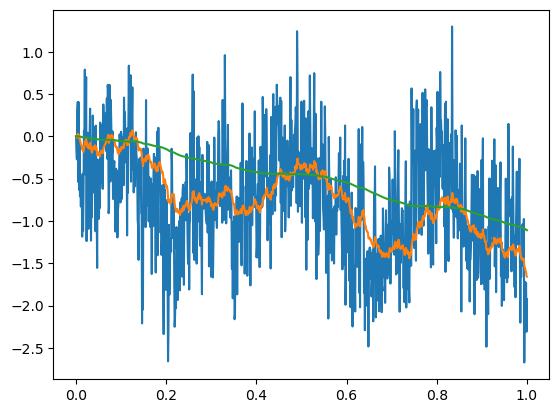

In [16]:
n_steps = 1024
T = 1

span = np.linspace(0, T, n_steps + 1)

out = simulate_bm_fbm(1, n_steps, T, 0.05)[1]
plt.plot(span, out.T)

out = simulate_bm_fbm(1, n_steps, T, 0.5)[1]
plt.plot(span, out.T)

out = simulate_bm_fbm(1, n_steps, T, 0.95)[1]
plt.plot(span, out.T)

In [17]:
def H_estimator(x, T):
    #return estimator of H from dissertation. Assume q = 2. 
    q = 2

    if x[0,] != 0:
        x = np.insert(x, 0, 0)
    diffs = np.abs(x[1:] - x[:-1])
    n_steps = diffs.shape[0]

    return np.log(1/n_steps * np.sum(diffs ** q)) / (q * np.log(T / n_steps))


In [26]:
exponents = np.arange(3, 15, 1)
H_estimators = np.zeros(len(exponents) - 1)

for i in range(len(exponents) - 1):
    out = simulate_bm_fbm(1, int(2 ** (i + 3)), T, 0.05)[1]
    H_estimators[i] = H_estimator(out[0], 1)

H_estimators

Beginning Simulation
Covariance Done
Beginning Simulation
Covariance Done
Beginning Simulation
Covariance Done
Beginning Simulation
Covariance Done
Beginning Simulation
Covariance Done
Beginning Simulation
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.Intel MKL WARNING: Support of Intel(R) Stream

array([0.07607077, 0.11104445, 0.02869321, 0.05292693, 0.06495406,
       0.06348754, 0.05789868, 0.05276676, 0.04887706, 0.05218054,
       0.05046109])

# 1. MLE

In [19]:

def obj(H, x, T, scalar = None):
    n_steps = x.shape[0]
    R = get_covariance_matrix(n_steps, H)

    if scalar is None: 
       scalar = (T / n_steps) ** (2 * H)

    determinant = np.linalg.det(R)
    R_inv = np.linalg.inv(R) / scalar

    return np.log(determinant) + n_steps * np.log(scalar) + n_steps * np.log(1 / n_steps * np.dot(x.T, np.dot(R_inv, x))) 

def max_MLE(x, T, scalar = None):

    #Add x_0 value if it is missing
    if x[0,] != 0:
        x = np.insert(x, 0, 0)

    diffs = x[1:] - x[:-1]
    n_steps = diffs.shape[0]

    #initial_guess = H_estimator(x, T)
    initial_guess = 0.5

    #Convergence issues noticed around H = 0.95, setting a bound of 0.94
    #Set lower bound of floating epsilon to stop H hitting exactly 0, which will cause LLF errors
    H = minimize(obj, initial_guess, args = (diffs, T, scalar), bounds = [(np.finfo(float).eps, 0.94)], method = "Powell", tol = 1e-10)

    if H.success:
        H_hat = H.x[0]
        R = get_covariance_matrix(n_steps, H_hat)
        if scalar is None:
            scalar = (T / n_steps) ** (2 * H_hat)
            R_inv = np.linalg.inv(R) / scalar
            sigma_hat = np.sqrt(1 / n_steps * np.dot(diffs.T, np.dot(R_inv, diffs)))
        else:
            sigma_hat = scalar
        return H_hat, sigma_hat

    return H.success

In [27]:
# Check this code works for a selection of cases

test_vals = np.arange(0.05, 0.15, 0.05)
test_scalars = np.arange(0.5, 2, 0.5)
val_errors = np.zeros((test_vals.shape[0], test_scalars.shape[0]))
scalar_errors = np.zeros((test_vals.shape[0], test_scalars.shape[0]))
for i, i_val in enumerate(test_vals):
    for j, j_val in enumerate(test_scalars):
        test_sim = simulate_bm_fbm(1, 1024, 1, i_val)[0]
        test_sim = test_sim[0, :].T * j_val
        test_H = max_MLE(test_sim, 1)
        val_errors[i, j] = test_H[0] - i_val
        scalar_errors[i, j] = test_H[1] - j_val
    

Beginning Simulation
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R

In [ ]:
val_errors

array([[0.45497959, 0.45497965, 0.45497974],
       [0.40497959, 0.40497965, 0.40497974]])

In [ ]:
scalar_errors

array([[0.00553437, 0.01106915, 0.01660472],
       [0.00553437, 0.01106915, 0.01660472]])

In [ ]:
sample_fbm = np.loadtxt('/Users/james.male/Dissertation/fBMPath2.txt')
# sample_fbm = np.loadtxt('C:\\Users\\jamma\Masters\\Dissertation\\fBMPath2.txt')
res = max_MLE(sample_fbm, 1)
res


(0.03567542508431033, 1.159697845593965)

# 2. Simulation

## 2.1 With given Paths

In [ ]:
class RFSV_model:
    def __init__(self, V0, S0, V, rho, H, T, B_path, BH_path, W_path, window_length):
        #inputs
        self.V0 = V0
        self.S0 = S0
        self.V = V
        self.rho = rho
        self.rho_bar = np.sqrt(1 - rho ** 2)
        self.window_length = window_length
        self.H = H
        self.T = T

        #Derived
        self.B_path = B_path
        self.BH_path = BH_path
        self.W_path = W_path
        
        self.n_steps = self.B_path.shape[0] - 1
        self.delta = self.T * self.window_length / self.n_steps


    def run_H_estimation(self):
        self.simulate_RFSV()
        self.variance_estimation()
        return self.est_H, self.MLE_H, self.realised_H #, self.realised_MLE_H
    
    def simulate_RFSV(self):
        
        B_diffs = get_diffs(self.B_path)
        W_diffs = get_diffs(self.W_path)

        S_path = np.zeros(self.n_steps + 1)
        V_path = np.zeros(self.n_steps + 1)

        V_path = self.V0 * np.exp(self.V * self.BH_path)
        S_path[0] = self.S0
        
        for i in range(self.n_steps):
            S_path[i + 1] = S_path[i] *\
                (1 + np.sqrt(V_path[i]) *\
                (self.rho * B_diffs[i] + self.rho_bar * W_diffs[i]))
        
        self.V_path = V_path
        self.S_path = S_path

    def variance_estimation(self):
        est_V = estimate_spot_variance(self.S_path, self.window_length)
        log_est_V = np.log(est_V / est_V[0])

        #This gives us a variance process up to time 1 - delta
        self.est_H = H_estimator(log_est_V, 1 - self.delta)

        self.realised_H = H_estimator(np.log(self.V_path / self.V0), 1)
        #self.realised_MLE_H = max_MLE(np.log(self.V_path / self.V0), 1)

        self.MLE_H = max_MLE(log_est_V, 1, scalar = 1)[0]

In [ ]:
# B_path_loc_05 = 'C:\\Users\\jamma\\Masters\\Dissertation\\Bpath.05.txt'
# BH_path_loc_05 = 'C:\\Users\\jamma\\Masters\\Dissertation\\BHpath.05.txt'
# W_path_loc_05 = 'C:\\Users\\jamma\\Masters\\Dissertation\\Wpath.05.txt'

B_path_loc_05 = '/Users/james.male/Dissertation/Bpath.05.txt'
BH_path_loc_05 = '/Users/james.male/Dissertation/BHpath.05.txt'
W_path_loc_05 = '/Users/james.male/Dissertation/Wpath.05.txt'

B_path_05 = add_zero(np.loadtxt(B_path_loc_05))
BH_path_05 = add_zero(np.loadtxt(BH_path_loc_05))
W_path_05 = add_zero(np.loadtxt(W_path_loc_05))

window_lengths = [16, 32, 64]

for window_length in window_lengths:
    test = RFSV_model(0.1, 1, 1, -0.65, 0.05, 1, B_path_05, BH_path_05, W_path_05, window_length)

    est_H, MLE_H, realised_H = test.run_H_estimation()
    print(est_H, MLE_H, realised_H)


0.0606503935273706 0.0357779374858494 0.05058175194263949
0.10751608160792792 0.05805869742559864 0.05058175194263949
0.19435280718536496 0.13661549661151695 0.05058175194263949


In [ ]:
B_path_loc_05 = '/Users/james.male/Dissertation/Bpath.10.txt'
BH_path_loc_05 = '/Users/james.male/Dissertation/BHpath.10.txt'
W_path_loc_05 = '/Users/james.male/Dissertation/Wpath.10.txt'

# B_path_loc_10 = 'C:\\Users\\jamma\\Masters\\Dissertation\\Bpath.10.txt'
# BH_path_loc_10 = 'C:\\Users\\jamma\\Masters\\Dissertation\\BHpath.10.txt'
# W_path_loc_10 = 'C:\\Users\\jamma\\Masters\\Dissertation\\Wpath.10.txt'

B_path_10 = add_zero(np.loadtxt(B_path_loc_10))
BH_path_10 = add_zero(np.loadtxt(BH_path_loc_10))
W_path_10 = add_zero(np.loadtxt(W_path_loc_10))

window_lengths = [16, 32, 64]

for window in window_lengths:
    test = RFSV_model(0.1, 1, 1, -0.65, 0.1, 1, B_path_10, BH_path_10, W_path_10, window)

    est_H, MLE_H, realised_H = test.run_H_estimation()
    print(est_H, MLE_H, realised_H)


0.08165382412454254 0.07363179120007167 0.10233969211163327
0.1363208336406822 0.12732884065283223 0.10233969211163327
0.18480804940462248 0.18387772568770458 0.10233969211163327


## 2.2 H = 0.5, 100 paths

In [ ]:
n_sims = 100
n_steps = 2 ** 16

simulated_H = np.zeros(n_sims)
sim_realised_H = np.zeros(n_sims)

S0 = 1
v = 1
rho = -0.65
V0 = 0.1
window_length = 512

rng = np.random.default_rng(seed = 1729)
B_paths = simulate_bm_fbm(n_sims, n_steps, 1, 0.5, rng)[0]
rng = np.random.default_rng(seed = 42)
W_paths = simulate_bm_fbm(n_sims, n_steps, 1, 0.5, rng)[0]

for i in range(n_sims):
    if (i + 1) % 5 == 0:
        print(f"{(i + 1) / 100:.0%}")
    model = RFSV_model(V0, v, S0, rho, 0.5, 1, B_paths[i, :], B_paths[i, :], W_paths[i, :], window_length)
    est_H, MLE_H, realised_H = model.run_H_estimation()

    simulated_H[i] = est_H
    sim_realised_H[i] = realised_H


5%
10%
15%
20%
25%
30%
35%
40%
45%
50%
55%
60%
65%
70%
75%
80%
85%
90%
95%
100%


(array([ 2., 14., 10., 16., 11., 13., 10., 10.,  4., 10.]),
 array([0.42408802, 0.42912163, 0.43415523, 0.43918884, 0.44422245,
        0.44925606, 0.45428966, 0.45932327, 0.46435688, 0.46939048,
        0.47442409]),
 <BarContainer object of 10 artists>)

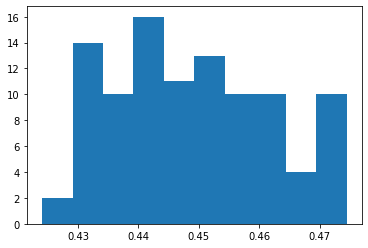

In [ ]:
plt.hist(simulated_H)

In [ ]:
print(np.percentile(simulated_H, 0.025))
print(np.percentile(simulated_H, 0.975))

0.42420632732290675
0.4287020266876933


## 2.3 Monte Carlo Pricing

In [ ]:
n_sims = 10000
n_steps = 2 ** 14 #consistent with simulated sample paths

S0 = 1
v = 1
rho = -0.65
V0 = 0.04
H = 0.1
dummy_window_length = 512

log_moneyness = np.arange(-0.5, 0.55, 0.05)
call_prices = np.zeros(log_moneyness.shape)

rng = np.random.default_rng(seed = 1729)
B_sim, BH_sim = simulate_bm_fbm(int(n_sims / 2), n_steps, 1, H, rng)
rng = np.random.default_rng(seed = 42)
W_sim = simulate_bm_fbm(int(n_sims / 2), n_steps, 1, 0.5, rng)[0]
print('Simulation done')

B_paths = np.vstack((B_sim, -B_sim))
BH_paths = np.vstack((BH_sim, -BH_sim))
W_paths = np.vstack((W_sim, -W_sim))
S1_paths = np.zeros([n_sims, 1])

for i in range(n_sims):
    if (i + 1) % 500 == 0:
        print(f"{(i + 1) / n_sims:.0%}")
    model = RFSV_model(V0, v, S0, rho, 0.1, 1, B_paths[i, :], B_paths[i, :], W_paths[i, :], dummy_window_length)
    model.simulate_RFSV()
    S1_paths[i] = model.S_path[-1]

Beginning Simulation
Covariance Done
Simulation done
5%
10%
15%
20%
25%
30%
35%
40%
45%
50%
55%
60%
65%
70%
75%
80%
85%
90%
95%
100%


In [ ]:
get_IV_from_price(1, 0, np.exp(-0.15), 1, 0, np.mean(np.maximum(S1_paths - np.exp(-0.15), 0)))

0.23483465975599874